# Tutorial: Create production machine learning pipelines


The core of a machine learning pipeline is to split a complete machine learning task into a multistep workflow. Each step is a manageable component that can be developed, optimized, configured, and automated individually. Steps are connected through well-defined interfaces. The Azure Machine Learning pipeline service automatically orchestrates all the dependencies between pipeline steps. The benefits of using a pipeline are standardized the MLOps practice, scalable team collaboration, training efficiency and cost reduction. To learn more about the benefits of pipelines, see [What are Azure Machine Learning pipelines](https://learn.microsoft.comazure/machine-learning/concept-ml-pipelines).

In this tutorial, you use Azure Machine Learning to create a production ready machine learning project, using Azure Machine Learning Python SDK v2.

This means you will be able to leverage the AzureML Python SDK to:

- Get a handle to your Azure Machine Learning workspace
- Create Azure Machine Learning data assets
- Create reusable Azure Machine Learning components
- Create, validate and run Azure Machine Learning pipelines

During this tutorial, you create an Azure Machine Learning pipeline to train a model for credit default prediction. The pipeline handles two steps: 

1. Data preparation
1. Training and registering the trained model

The next image shows a simple pipeline as you'll see it in the Azure studio once submitted.

![Screenshot that shows the AML Pipeline](./media/pipeline-overview.jpg "Overview of the pipeline")


## Prerequisites

- Prereq 1: Execute the <a href="00_SetupCLIEnvironment.ipynb">CLI Environment Setup Tutorial</a> in this notebook to load custom environment settings (if any)
- Please create a Data asset by following steps in <a href="02_UploadData_CLI.ipynb">CLI Upload Data Tutorial</a>
- Please train a base model by following steps in <a href="03a_Train_Model_CLI.ipynb">CLI Model Training Tutorial</a>

In [1]:
%pip install nbformat

Note: you may need to restart the kernel to use updated packages.


In [2]:

%run 00_SetupCLIEnvironment.ipynb

Loading CUSTOM environment
Reloaded dotenv extension
Loading CUSTOM environment
aigbb-aml-bootcamp
Checking 'az ml' extension...

'az ml' extension installed


## Set up the pipeline resources

The Azure Machine Learning framework can be used from CLI, Python SDK, or studio interface. In this example, you use the Azure Machine Learning Python SDK v2 to create a pipeline. 

Before creating the pipeline, you need the following resources:

* The data asset for training
* The software environment to run the pipeline
* A compute resource to where the job runs

## Access the registered data asset using CLI

Start by getting the data that you previously registered in [Tutorial: Upload, access and explore your data](explore-data.ipynb).

* Azure Machine Learning uses a `Data` object to register a reusable definition of data, and consume data within a pipeline.

Since this is the first time that you're making a call to the workspace, you may be asked to authenticate. Once the authentication is complete, you then see the dataset registration completion message.

In [3]:
!az ml data show --name "credit_cards" --label "latest" 

{
  "creation_context": {
    "created_at": "2023-11-15T12:54:39.404122+00:00",
    "created_by": "Anton Slutsky",
    "created_by_type": "User",
    "last_modified_at": "2023-11-15T12:54:39.412977+00:00"
  },
  "description": "Data asset created from local file.",
  "id": "/subscriptions/781b03e7-6eb7-4506-bab8-cf3a0d89b1d4/resourceGroups/aigbb-aml-bootcamp/providers/Microsoft.MachineLearningServices/workspaces/aigbb-aml-bootcamp/data/credit_cards/versions/1",
  "name": "credit_cards",
  "path": "azureml://subscriptions/781b03e7-6eb7-4506-bab8-cf3a0d89b1d4/resourcegroups/aigbb-aml-bootcamp/workspaces/aigbb-aml-bootcamp/datastores/workspaceblobstore/paths/LocalUpload/4b1dfc4d12429b46389cabdf25b886a2/default_of_credit_card_clients.csv",
  "properties": {},
  "resourceGroup": "aigbb-aml-bootcamp",
  "tags": {},
  "type": "uri_file",
  "version": "1"
}


## Create a compute resource to run your pipeline (Optional)

You can **skip this step** if you want to use [serverless compute (preview)](https://learn.microsoft.com/azure/machine-learning/how-to-use-serverless-compute?view=azureml-api-2&tabs=python) to run the training job. Through serverless compute, Azure Machine Learning takes care of creating, scaling, deleting, patching and managing compute, along with providing managed network isolation, reducing the burden on you. 

Each step of an Azure Machine Learning pipeline can use a different compute resource for running the specific job of that step. It can be single or multi-node machines with Linux or Windows OS, or a specific compute fabric like Spark.

In this section, you provision a Linux  [compute cluster](https://docs.microsoft.com/azure/machine-learning/how-to-create-attach-compute-cluster?tabs=python). See the [full list on VM sizes and prices](https://azure.microsoft.com/en-ca/pricing/details/machine-learning/) .

For this tutorial, you only need a basic cluster so use a Standard_DS3_v2 model with 2 vCPU cores, 7-GB RAM and create an Azure Machine Learning Compute.
> [!TIP]
> If you already have a compute cluster, replace "cpu-cluster" in the next code block with the name of your cluster.  This will keep you from creating another one.


In [13]:
%env CLUSTER_NAME cpu-cluster
!az ml compute create -n cpu-cluster --type amlcompute \
    --min-instances 0 \
    --max-instances 4 \
    --size STANDARD_DS3_V2 \
    --idle-time-before-scale-down 180 \
    --tier Dedicated

env: CLUSTER_NAME=cpu-cluster
{\ Finished ..
  "enable_node_public_ip": true,
  "id": "/subscriptions/f1ea6ed8-82f3-416d-881b-8b376218bc85/resourceGroups/rg_aml/providers/Microsoft.MachineLearningServices/workspaces/aml-default/computes/cpu-cluster",
  "idle_time_before_scale_down": 180,
  "location": "eastus",
  "max_instances": 4,
  "min_instances": 0,
  "name": "cpu-cluster",
  "network_settings": {},
  "provisioning_state": "Succeeded",
  "resourceGroup": "rg_aml",
  "size": "STANDARD_DS3_V2",
  "ssh_public_access_enabled": true,
  "tier": "dedicated",
  "type": "amlcompute"
}


==========================================================================================
# OPTIONAL- Run this if you have not done previous steps!
## Create a job environment for pipeline steps. 

So far, you've created a development environment on the compute instance, your development machine. You also need an environment to use for each step of the pipeline. Each step can have its own environment, or you can use some common environments for multiple steps.

In this example, you create a conda environment for your jobs, using a conda yaml file.
First, create a directory to store the file in.

## Build the training pipeline

Now that you have all assets required to run your pipeline, it's time to build the pipeline itself.

Azure Machine Learning pipelines are reusable ML workflows that usually consist of several components. The typical life of a component is:

- Write the yaml specification of the component, or create it programmatically using the `az component` CLI command.
- Load that component from the pipeline code.
- Implement the pipeline using the component's inputs, outputs and parameters.
- Submit the pipeline.

There are two ways to create a component, programmatic and yaml definition. The next two sections walk you through creating a component both ways. You can either create the two components trying both options or pick your preferred method.

> [!NOTE]
> In this tutorial for simplicity we are using the same compute for all components. However, you can set different computes for each component, for example by adding a line like `"compute: azureml:cpu-cluster"`. To view an example of building a pipeline with different computes for each component, see the [Basic pipeline job section in the cifar-10 pipeline tutorial](https://github.com/Azure/azureml-examples/blob/main/sdk/python/jobs/pipelines/2b_train_cifar_10_with_pytorch/train_cifar_10_with_pytorch.ipynb).

### Create component 1: data prep (using SDK programmatic definition)

Let's start by creating the first component. This component handles the preprocessing of the data. The preprocessing task is performed in the *data_prep.py* Python file.

First create a source folder for the data_prep component:

In [10]:
!mkdir components\data_prep

A subdirectory or file components\data_prep already exists.


This script performs the simple task of splitting the data into train and test datasets. Azure Machine Learning mounts datasets as folders to the computes, therefore, we created an auxiliary `select_first_file` function to access the data file inside the mounted input folder. 

[MLFlow](https://learn.microsoft.com/articles/machine-learning/concept-mlflow) is used to log the parameters and metrics during our pipeline run.

In [10]:
%%writefile components/data_prep/data_prep.py
import os
import argparse
import pandas as pd
from sklearn.model_selection import train_test_split
import logging
import mlflow


def main():
    """Main function of the script."""

    # input and output arguments
    parser = argparse.ArgumentParser()
    parser.add_argument("--data", type=str, help="path to input data")
    parser.add_argument("--test_train_ratio", type=float, required=False, default=0.25)
    parser.add_argument("--train_data_csv", type=str, help="name of train data")
    parser.add_argument("--test_data_csv", type=str, help="name of test data")
    args = parser.parse_args()

    # Start Logging
    mlflow.start_run()

    print(" ".join(f"{k}={v}" for k, v in vars(args).items()))

    print("input data:", args.data)

    credit_df = pd.read_csv(args.data, header=1, index_col=0)

    mlflow.log_metric("num_samples", credit_df.shape[0])
    mlflow.log_metric("num_features", credit_df.shape[1] - 1)

    credit_train_df, credit_test_df = train_test_split(
        credit_df,
        test_size=args.test_train_ratio,
    )

    os.makedirs(args.train_data_csv, exist_ok=True)
    os.makedirs(args.test_data_csv, exist_ok=True)

    print("???!!!", args.train_data_csv)

    # output paths are mounted as folder, therefore, we are adding a filename to the path
    # train_data_path = os.path.join(args.train_data, "data.csv")
    # print("train_data_path", os.path.abspath(train_data_path))


    credit_train_df.to_csv(os.path.join(os.getcwd(), args.train_data_csv, "data.csv"), index=False)

    # test_data_path = os.path.join(args.test_data, "data.csv")
    # print("test_data_path", os.path.abspath(test_data_path))
    credit_test_df.to_csv(os.path.join(os.getcwd(), args.test_data_csv, "data.csv"), index=False)

    # Stop Logging
    mlflow.end_run()


if __name__ == "__main__":
    main()

Overwriting components/data_prep/data_prep.py


Now that you have a script that can perform the desired task, create an Azure Machine Learning Component from it.

Use the general purpose `component` that can run command line actions. This command line action uses a YAML configuration file to configure a run script execution. The inputs/outputs are specified in the YAML file via the `${{ ... }}` notation.


Now create a component configuration file that references the conda.yml (above) to create a job and initialize execution.

In [9]:
%%writefile components/data_prep/cli_job.yml
$schema: https://azuremlschemas.azureedge.net/latest/commandJob.schema.json
name: data_prep_component
code: .
command: >-
  python data_prep.py 
  --data ${{inputs.data}} 
  --test_train_ratio ${{inputs.test_train_ratio}} 
  --train_data_csv ${{outputs.train_data_csv}}
  --test_data_csv ${{outputs.test_data_csv}}
inputs:
  data: 
    type: uri_file
  test_train_ratio: 
    type: number
  train_data_csv: 
    type: string
  test_data_csv: 
    type: string
outputs:
  train_data_csv:
    type: uri_folder
    mode: rw_mount
  test_data_csv:
    type: uri_folder
    mode: rw_mount
environment: azureml:aigbb-aml-bootcamp-environment@latest
compute: azureml:cpu-cluster
display_name: 04a_Pipeline_DataPrep_CLI_Job
experiment_name: aigbb-aml-bootcamp
description: Train a Machine Learning model using a workspace Data asset.


Overwriting components/data_prep/cli_job.yml


In [5]:
!az ml component create -f components/data_prep/cli_job.yml

{
  "$schema": "https://azuremlschemas.azureedge.net/latest/commandJob.schema.json",
  "code": "azureml:/subscriptions/781b03e7-6eb7-4506-bab8-cf3a0d89b1d4/resourceGroups/aigbb-aml-bootcamp/providers/Microsoft.MachineLearningServices/workspaces/aigbb-aml-bootcamp/codes/ea7173b8-137c-4f01-9822-74a507f0b880/versions/1",
  "command": "python data_prep.py  --data ${{inputs.data}}  --test_train_ratio ${{inputs.test_train_ratio}}  --train_data_csv ${{outputs.train_data_csv}} --test_data_csv ${{outputs.test_data_csv}}",
  "creation_context": {
    "created_at": "2023-11-17T14:22:07.835009+00:00",
    "created_by": "Anton Slutsky",
    "created_by_type": "User",
    "last_modified_at": "2023-11-17T14:22:07.988964+00:00",
    "last_modified_by": "Anton Slutsky",
    "last_modified_by_type": "User"
  },
  "description": "Train a Machine Learning model using a workspace Data asset.",
  "display_name": "04a_Pipeline_DataPrep_CLI_Job",
  "environment": "azureml:/subscriptions/781b03e7-6eb7-4506-bab

### Create component 2: training (using yaml definition)

The second component that you create consumes the training and test data, train a tree based model and return the output model. Use Azure Machine Learning logging capabilities to record and visualize the learning progress.

You used the `CommandComponent` class to create your first component. This time you use the yaml definition to define the second component. Each method has its own advantages. A yaml definition can actually be checked-in along the code, and would provide a readable history tracking. The programmatic method using `CommandComponent` can be easier with built-in class documentation and code completion.

Create the directory for this component:

In [12]:
!mkdir .\components\train

Create the training script in the directory:


In [13]:
%%writefile components/train/train.py
import argparse
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
import os
import pandas as pd
import mlflow


def select_first_file(path):
    """Selects first file in folder, use under assumption there is only one file in folder
    Args:
        path (str): path to directory or file to choose
    Returns:
        str: full path of selected file
    """
    
    print("path: ", path)
    
    files = os.listdir(path)
    
    print("Files in path: ", files)


    return os.path.join(path, files[0])


# Start Logging
mlflow.start_run()

# enable autologging
mlflow.sklearn.autolog()

os.makedirs("./outputs", exist_ok=True)


def main():
    """Main function of the script."""

    # input and output arguments
    parser = argparse.ArgumentParser()
    parser.add_argument("--train_data_csv", type=str, help="path to train data")
    parser.add_argument("--test_data_csv", type=str, help="path to test data")
    parser.add_argument("--n_estimators", required=False, default=100, type=int)
    parser.add_argument("--learning_rate", required=False, default=0.1, type=float)
    parser.add_argument("--registered_model_name", type=str, help="model name")
    parser.add_argument("--model", type=str, help="path to model file")
    args = parser.parse_args()
    

    # paths are mounted as folder, therefore, we are selecting the file from folder
    train_df = pd.read_csv(select_first_file(args.train_data_csv))
    #train_df = pd.read_csv(args.train_data_csv)

    # Extracting the label column
    y_train = train_df.pop("default payment next month")

    # convert the dataframe values to array
    X_train = train_df.values

    # paths are mounted as folder, therefore, we are selecting the file from folder
    test_df = pd.read_csv(select_first_file(args.test_data_csv))
    #test_df = pd.read_csv(args.test_data_csv)

    # Extracting the label column
    y_test = test_df.pop("default payment next month")

    # convert the dataframe values to array
    X_test = test_df.values

    print(f"Training with data of shape {X_train.shape}")

    clf = GradientBoostingClassifier(
        n_estimators=args.n_estimators, learning_rate=args.learning_rate
    )
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)

    print(classification_report(y_test, y_pred))

    # Registering the model to the workspace
    print("Registering the model via MLFlow")
    mlflow.sklearn.log_model(
        sk_model=clf,
        registered_model_name=args.registered_model_name,
        artifact_path=args.registered_model_name,
    )

    # Saving the model to a file
    mlflow.sklearn.save_model(
        sk_model=clf,
        path=os.path.join(args.model, "trained_model"),
    )

    # Stop Logging
    mlflow.end_run()


if __name__ == "__main__":
    main()

Writing components/train/train.py


As you can see in this training script, once the model is trained, the model file is saved and registered to the workspace. Now you can use the registered model in inferencing endpoints.

For the environment of this step, you use one of the built-in (curated) Azure Machine Learning environments. The tag `azureml`, tells the system to use look for the name in curated environments.
First, create the *yaml* file describing the component:

In [14]:
%%writefile ./components/train/train.yml
# <component>
name: train_credit_defaults_component
display_name: Train Credit Defaults Component
# version: 1 # Not specifying a version will automatically update the version
type: command
inputs:
  train_data_csv: 
    type: uri_folder
    mode: ro_mount
  test_data_csv: 
    type: uri_file
    mode: ro_mount
  learning_rate:
    type: number     
  registered_model_name:
    type: string
outputs:
  model:
    type: uri_folder
code: .
environment: azureml:aigbb-aml-bootcamp-environment@latest
command: >-
  python train.py 
  --train_data ${{inputs.train_data_csv}} 
  --test_data ${{inputs.test_data_csv}} 
  --learning_rate ${{inputs.learning_rate}}
  --registered_model_name ${{inputs.registered_model_name}} 
  --model ${{outputs.model}}
# </component>


Writing ./components/train/train.yml


Now create and register the component.  Registering it allows you to re-use it in other pipelines.  Also, anyone else with access to your workspace can use the registered component.

In [6]:
!az ml component create -f  ./components/train/train.yml

Uploading train (0.0 MBs): 100%|█████████| 3664/3664 [00:00<00:00, 32937.54it/s]


{
  "code": "azureml:/subscriptions/f1ea6ed8-82f3-416d-881b-8b376218bc85/resourceGroups/rg_aml/providers/Microsoft.MachineLearningServices/workspaces/aml-default/codes/ef0ba804-f371-4eb7-bb1b-9af3d0f5d45c/versions/1",
  "command": "python train.py  --train_data ${{inputs.train_data_csv}}  --test_data ${{inputs.test_data_csv}}  --learning_rate ${{inputs.learning_rate}} --registered_model_name ${{inputs.registered_model_name}}  --model ${{outputs.model}}",
  "creation_context": {
    "created_at": "2023-11-13T18:50:40.129282+00:00",
    "created_by": "alex zeltov",
    "created_by_type": "User",
    "last_modified_at": "2023-11-13T18:50:40.263182+00:00",
    "last_modified_by": "alex zeltov",
    "last_modified_by_type": "User"
  },
  "display_name": "Train Credit Defaults Component",
  "environment": "azureml://registries/azureml/environments/AzureML-sklearn-1.0-ubuntu20.04-py38-cpu/versions/1",
  "id": "

The newly created components may be found in the Components section of the Azure ML workspace
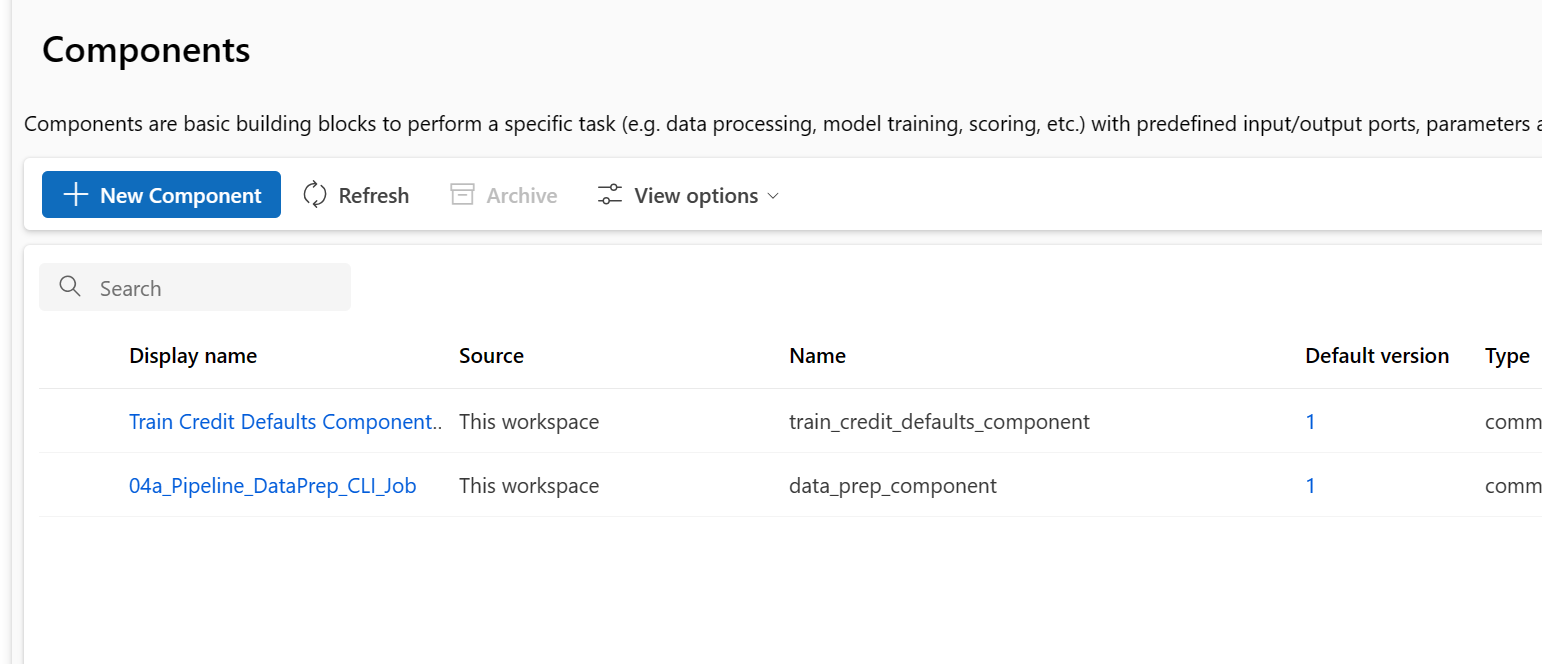

### Create the pipeline from components

Now that both your components are defined and registered, you can start implementing the pipeline.


Here, you use *input data*, *split ratio* and *registered model name* as input variables. Then call the components and connect them via their inputs/outputs identifiers. The outputs of each step can be accessed via the `.outputs` property.


A YAML configuration file is used to represent the Azure Machine Learning pipeline structure as a directed acyclic graph (DAG). In the YAML configuration, we can specify the pipeline description and default resources like compute and storage.  Similar to components, pipelines can have inputs and output. You can then create multiple instances of a single pipeline with different inputs.

Here, we used *input data*, *split ratio* and *registered model name* as input variables. We then call the components and connect them via their inputs/outputs identifiers. The outputs of each step can be accessed via the `.outputs` property.

Create a pipeline.yml file to describe the structure of the pipeline DAG:

In [24]:
%%writefile ./components/pipeline.yml
$schema: https://azuremlschemas.azureedge.net/latest/pipelineJob.schema.json
type: pipeline

display_name: 04a_Pipeline_DataPrep_Train_CLI_Pipeline
description: Pipeline with 2 component jobs with data dependencies

settings:
  default_compute: azureml:cpu-cluster

outputs:
  final_model:
    mode: upload

jobs:
  component_data_prep:
    type: command
    component: azureml:data_prep_component@latest
    inputs:
      data: 
        type: uri_file
        path: azureml:credit_cards@latest
      test_train_ratio: 0.25
      train_data_csv: train 
      test_data_csv: test
    outputs:
      train_data_csv: 
        mode: upload
      test_data_csv: 
        mode: upload
  component_train:
    type: command
    component: azureml:train_credit_defaults_component@latest
    inputs:
      train_data_csv: ${{parent.jobs.component_data_prep.outputs.train_data_csv}}
      test_data_csv: ${{parent.jobs.component_data_prep.outputs.test_data_csv}}
      learning_rate: 0.2
      registered_model_name: credit_default_model
    outputs:
      model: ${{parent.outputs.final_model}}

Writing ./components/pipeline.yml


In [25]:
!az ml job create --file ./components/pipeline.yml

Class AutoDeleteSettingSchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class AutoDeleteConditionSchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class BaseAutoDeleteSettingSchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class IntellectualPropertySchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class ProtectionLevelSchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class BaseIntellectualPropertySchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
{
  "creation_context": {
    "created

Now use your pipeline definition to instantiate a pipeline with your dataset, split rate of choice and the name you picked for your model.

You can track the progress of your pipeline, by using the link generated in the previous cell. When you first select this link, you may see that the pipeline is still running. Once it's complete, you can examine each component's results.

Double-click the **Train Credit Defaults Model** component. 

There are two important results you'll want to see about training:

* View your logs:
    1. Select the **Outputs+logs** tab.
    1. Open the folders to `user_logs` > `std_log.txt`
    This section shows the script run stdout.
    ![Screenshot of std_log.txt.](media/user-logs.jpg)

* View your metrics: Select the **Metrics** tab.  This section shows different logged metrics. In this example. mlflow `autologging`, has automatically logged the training metrics.
    
    ![Screenshot shows logged metrics.txt.](./media/metrics.jpg)

## Deploy the model as an online endpoint
To learn how to deploy your model to an online endpoint, see [Deploy a model as an online endpoint tutorial](https://learn.microsoft.com/en-us/azure/machine-learning/tutorial-deploy-model).


## Next Steps

Learn how to [Schedule machine learning pipeline jobs](https://learn.microsoft.com/azure/machine-learning/how-to-schedule-pipeline-job)